In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

sys.path.append('../')

In [37]:
from dataset_parser import (
    get_ordered_syllable_for_song,
    get_recording_time_from_filename,
    load_single_bird_syllable_csv,
    split_dataset_by_surgery_date
)

import pprint
file_path = '../Modeling_phys_canary/USA5288_decoded.csv'

results = load_single_bird_syllable_csv(file_path)

print(f'SONGS IN DATASET: {len(results)}')
pprint.pprint(results[1])

import json
from datetime import datetime
json_file_path = '../Modeling_phys_canary/USA5288_creation_data.json'

with open(json_file_path, 'r') as f:
    data = json.load(f)

    surgery_treatment_date = datetime.strptime(
        data['treatment_date'], '%Y-%m-%d')

print(f'Surgery Treatment Date: {surgery_treatment_date}')

results_pre_surgery, results_post_surgery = split_dataset_by_surgery_date(results, surgery_treatment_date)
print(f'PRE SURG SAMPLES: {len(results_pre_surgery)}, POST SURG SAMPLES: {len(results_post_surgery)}')

SONGS IN DATASET: 52151
{'animal_id': 'USA5288',
 'file_name': 'USA5288_45355.32438532_3_4_9_0_38.wav',
 'ordered_and_timed_syllables': [('8', 0.0, 1813.3333333333335),
                                 ('21', 1813.3333333333335, 3348.730158730159),
                                 ('22', 3348.730158730159, 4425.396825396826),
                                 ('21', 4425.396825396826, 4611.587301587302),
                                 ('22', 4611.587301587302, 4619.68253968254),
                                 ('21', 4619.68253968254, 4622.380952380952),
                                 ('22', 4622.380952380952, 4625.079365079366),
                                 ('21', 4625.079365079366, 4630.476190476191),
                                 ('26', 4630.476190476191, 4751.904761904762),
                                 ('23', 4751.904761904762, 5010.952380952382),
                                 ('2', 5010.952380952382, 5785.396825396826),
                                 ('3', 5785

In [85]:
import math
import pandas as pd

def build_song_sequences_with_timing(dataset):
    """Builds song sequences from a dataset of syllables.

    This function considers the timing of syllables in a song. It works
    by calculating the average length of each syllable and then using that
    to determine the number of times a syllable should be repeated in a song.
    """
    syllables_with_len = []
    for result in dataset:
        for song_syllable in result['ordered_and_timed_syllables']:
            s, start, end = song_syllable

            assert type(s) == str, f"Expected string, got {type(s)}"
            syllables_with_len.append({
                'syllable': s,
                'length': end - start
            })

    df = pd.DataFrame(syllables_with_len)
    syllable_stats = df.groupby("syllable")["length"].agg(["mean", "std"])

    songs = []
    for result in dataset:
        song = []

        if len(result['ordered_and_timed_syllables']) == 0:
            continue

        for song_syllable in result['ordered_and_timed_syllables']:
            s, start, end = song_syllable

            l = end - start

            syllable_mean = syllable_stats['mean'][s]

            num_syllables = math.ceil(l / syllable_mean)

            song.extend([s] * num_syllables)

        songs.append(song)
    return songs

pre_surgery_sequences = build_song_sequences_with_timing(results_pre_surgery)
post_surgery_sequences = build_song_sequences_with_timing(results_post_surgery)

len(pre_surgery_sequences), len(post_surgery_sequences)

(7507, 4076)

In [ ]:
from train_pst_utils import train_pst

L = 5

pre_surgery_pst = train_pst(pre_surgery_sequences, L)
alphabet = pre_surgery_pst.alphabet
post_surgery_pst = train_pst(post_surgery_sequences, alphabet=alphabet)

print(alphabet)

30 30


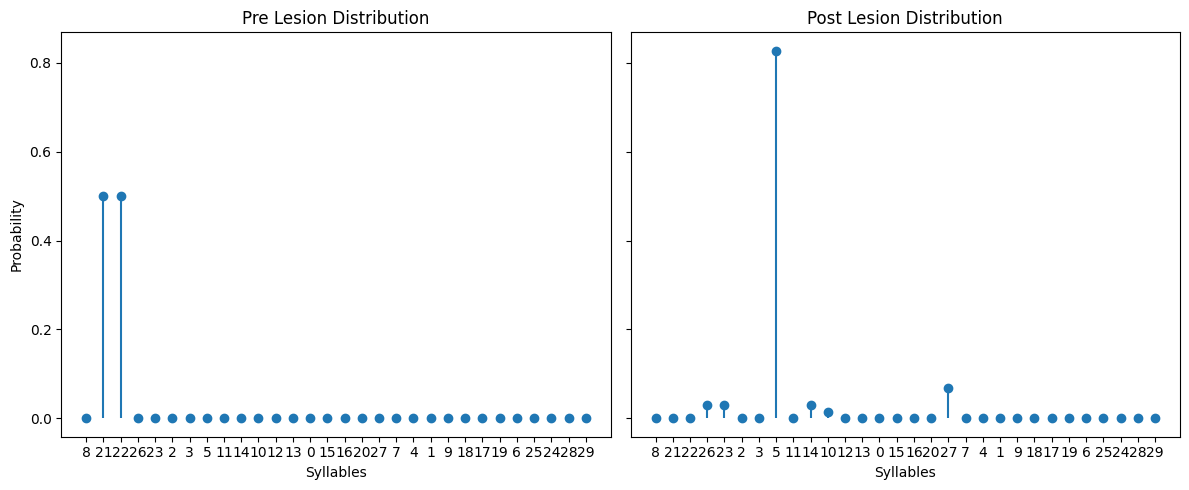

TypeError: calculate_metrics() missing 1 required positional argument: 'post_dist'

In [ ]:

from train_pst_utils import plot_before_and_after_distribution, calculate_metrics

import pprint

order = 3

assert np.array_equal(pre_surgery_pst.alphabet, post_surgery_pst.alphabet), "Alphabets must be the same"

for idx in range(len(pre_surgery_pst.tree[order]['p'])):
    print(len(pre_surgery_pst.tree[order]['p'][idx]), len(post_surgery_pst.tree[order]['p'][idx]))

    pre_probs = pre_surgery_pst.tree[order]['p'][idx]
    post_probs = post_surgery_pst.tree[order]['p'][idx]

    norm_pre_probs = (pre_probs + (1e-12)) / np.sum(pre_probs)
    norm_post_probs = (post_probs + (1e-12)) / np.sum(post_probs)

    plot_before_and_after_distribution(alphabet, norm_pre_probs, norm_post_probs)
    metrics = calculate_metrics(norm_pre_probs, norm_post_probs)

    pprint.pprint(metrics)


In [ ]:
from train_pst_utils import calculate_metrics, plot_before_and_after_distribution


assert np.array_equal(pre_surgery_pst.alphabet, post_surgery_pst.alphabet), "Alphabets must be the same"

for order in range(1, L+1):
    print(f'ORDER: {order}')

    for idx in range(len(pre_surgery_pst.tree[order]['p'])):
        try:
            print(len(pre_surgery_pst.tree[order]['p'][idx]), len(post_surgery_pst.tree[order]['p'][idx]))
        except:
            continue

        print(f'idx: {idx}')

        pre_probs = pre_surgery_pst.tree[order]['p'][idx]
        post_probs = post_surgery_pst.tree[order]['p'][idx]

        norm_pre_probs = (pre_probs + (1e-12)) / np.sum(pre_probs)
        norm_post_probs = (post_probs + (1e-12)) / np.sum(post_probs)

        #plot_before_and_after_distribution(alphabet, norm_pre_probs, norm_post_probs)
        metrics = calculate_metrics(order, idx, norm_pre_probs, norm_post_probs)



        pprint.pprint(metrics)


ORDER: 1
30 30
idx: 0
{"Earth Mover's Distance": 4.421220440170439,
 'Information Gain': -0.6443310912375102,
 'Kullback-Leibler Divergence': 0.4575817064689331,
 'order': 1,
 'post_entropy': 1.6493532091255485,
 'pre_entropy': 1.0050221178880383,
 'syllable_idx': 0}
30 30
idx: 1
{"Earth Mover's Distance": 3.6785602625376272,
 'Information Gain': -0.21323267977442795,
 'Kullback-Leibler Divergence': 0.4370150698980308,
 'order': 1,
 'post_entropy': 1.3976566858109667,
 'pre_entropy': 1.1844240060365387,
 'syllable_idx': 1}
30 30
idx: 2
{"Earth Mover's Distance": 4.0987735127886,
 'Information Gain': -0.6805632543601741,
 'Kullback-Leibler Divergence': 14.914148422343454,
 'order': 1,
 'post_entropy': 1.802262893933673,
 'pre_entropy': 1.1216996395734988,
 'syllable_idx': 2}
30 30
idx: 3
{"Earth Mover's Distance": 3.3610865147317757,
 'Information Gain': 0.9397497845809949,
 'Kullback-Leibler Divergence': 8.554837110348162,
 'order': 1,
 'post_entropy': 0.9839950458934915,
 'pre_entropy

In [95]:
import pandas as pd

df = pd.DataFrame(entropies, columns=['order', 'syllable_idx', 'pre_entropy', 'post_entropy'])
df['entropy_diff'] = df['pre_entropy'] - df['post_entropy']

avg_entropy = df.groupby('order')[['pre_entropy', 'post_entropy', 'entropy_diff']].agg(['mean', 'var'])
avg_entropy

pre_entropy           post_entropy           entropy_diff          
             mean       var         mean       var         mean       var
order                                                                    
1        1.278675  0.116116     1.281457  0.103757    -0.002782  0.265483
2        0.764648  0.155606     0.808176  0.158593    -0.043528  0.308718
3        0.668208  0.260955     0.658635  0.228560     0.009573  0.468977
4        0.568266  0.233451     0.543516  0.232382     0.024750  0.508030

In [49]:
order = 3
print(pre_surgery_pst.tree[order].keys())
print('parent', len(pre_surgery_pst.tree[order]['parent']))
print('label', len(pre_surgery_pst.tree[order]['label']))
print('internal', len(pre_surgery_pst.tree[order]['internal']))
print('p', len(pre_surgery_pst.tree[order]['p']))
print('l', len(pre_surgery_pst.tree[order]['f']))

pre_surgery_pst.tree[order]['p'][0].shape

dict_keys(['string', 'parent', 'label', 'internal', 'g_sigma_s', 'p', 'f'])
parent 275
label 275
internal 275
p 275
l 275


(30,)

In [ ]:
idx = 2

node_string = pre_surgery_pst.tree[order]['string'][idx]
print(node_string)     # LIST INDEXES OF SYLLABLES IN ALPHABET
print(pre_surgery_pst.tree[order]['parent'][idx])
print(pre_surgery_pst.tree[order]['label'][idx])      # ACTUAL SYLLABLES AT THIS NODE
print(pre_surgery_pst.tree[order]['internal'][idx])   # ???

expected_label = [
    pre_surgery_pst.alphabet[s] for s in node_string
]
assert expected_label == pre_surgery_pst.tree[order]['label'][idx], "Expected label does not match"

# SO EACH ORDER 3 NODE IS has a IDX
# EACH p for each node has len(alphabet) transition probabilities
# these are the probabilities that the next word will be that syllable
print(pre_surgery_pst.tree[order]['p'][idx])

[12, 10, 0]
(0, 2)
['13', '10', '8']
0
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 3.57015352e-05 0.00000000e+00
 1.78507676e-05 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]


In [41]:
pre_surgery_pst.alphabet[0]

'8'